# 部署 Single Shot Multibox Detector(SSD) 模型

**原作者**：[Yao Wang](https://github.com/kevinthesun)，[Leyuan Wang](https://github.com/Laurawly)

本文是使用 TVM 部署 SSD 模型的介绍性教程。使用 GluonCV 预训练 SSD 模型，并将其转换为 Relay IR。

In [1]:
import set_env

In [2]:
import tvm
from tvm import te

from matplotlib import pyplot as plt
from tvm import relay
from tvm.contrib import graph_executor
from tvm.contrib.download import download_testdata
from gluoncv import model_zoo, data, utils

/usr/local/lib/python3.8/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.8.2+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


## 初始和设置参数

```{note}
:class: alert alert-info

现在支持在 CPU 和 GPU 上编译 SSD。

为了在 CPU 上获得最佳的推理性能，根据你的设备改变目标参数，按照 {ref}`tune_relay_x86` 来调优 x86 CPU，按照 {ref}`tune_relay_arm` 来调优 ARM CPU。

为了在 Intel graphics 上获得最佳的推理性能，将目标参数改为 `opencl -device=intel_graphics`。但是当在 Mac 上使用 Intel graphics 时，target 需要设置为 `opencl`，只是因为 Mac 上不支持 Intel subgroup 扩展。

为了在基于 ``cuda`` 的 GPU 上获得最佳的推理性能，将目标参数改为 ``cuda``；对于基于 ``opencl`` 的 GPU，根据你的设备更改目标参数为 ``opencl``。
```

In [3]:
supported_model = [
    "ssd_512_resnet50_v1_voc",
    "ssd_512_resnet50_v1_coco",
    "ssd_512_resnet101_v2_voc",
    "ssd_512_mobilenet1.0_voc",
    "ssd_512_mobilenet1.0_coco",
    "ssd_300_vgg16_atrous_voc",
    "ssd_512_vgg16_atrous_coco",
]

model_name = supported_model[0]
dshape = (1, 3, 512, 512)

下载并预处理演示图像。

In [4]:
im_fname = download_testdata(
    "https://github.com/dmlc/web-data/blob/main/" + "gluoncv/detection/street_small.jpg?raw=true",
    "street_small.jpg",
    module="data",
)
x, img = data.transforms.presets.ssd.load_test(im_fname, short=512)

为 CPU 转换和编译模型。

In [5]:
block = model_zoo.get_model(model_name, pretrained=True)


def build(target):
    mod, params = relay.frontend.from_mxnet(block, {"data": dshape})
    with tvm.transform.PassContext(opt_level=3):
        lib = relay.build(mod, target, params=params)
    return lib

/usr/local/lib/python3.8/dist-packages/mxnet/gluon/block.py:1784: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]




```{admonition} 创建 TVM 运行时并进行推理
:class: alert alert-info

如果你在 cmake 期间设定 `-DUSE_THRUST=ON` 启用了 thrust，则使用 ``target = "cuda -libs"`` 来启用基于 thrust 的排序。
```

In [6]:
def run(lib, dev):
    # Build TVM runtime
    m = graph_executor.GraphModule(lib["default"](dev))
    tvm_input = tvm.nd.array(x.asnumpy(), device=dev)
    m.set_input("data", tvm_input)
    # execute
    m.run()
    # get outputs
    class_IDs, scores, bounding_boxs = m.get_output(0), m.get_output(1), m.get_output(2)
    return class_IDs, scores, bounding_boxs


for target in ["llvm", "cuda"]:
    dev = tvm.device(target, 0)
    if dev.exist:
        lib = build(target)
        class_IDs, scores, bounding_boxs = run(lib, dev)

/media/pc/data/4tb/lxw/books/tvm/python/tvm/driver/build_module.py:263: UserWarning: target_host parameter is going to be deprecated. Please pass in tvm.target.Target(target, host=target_host) instead.
  warnings.warn(
One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.
[16:03:50] /media/pc/data/4tb/lxw/books/tvm/src/te/schedule/bound.cc:119: not in feed graph consumer = hybrid(hybrid_nms, 0xee3a750)
[16:05:18] /media/pc/data/4tb/lxw/books/tvm/src/te/schedule/bound.cc:119: not in feed graph consumer = extern(nms, 0x327eb7c0)
[16:05:18] /media/pc/data/4tb/lxw/books/tvm/src/te/schedule/bound.cc:119: not in feed graph consumer = extern(nms, 0x327eb7c0)
[16:05:18] /media/pc/data/4tb/lxw/books/tvm/src/te/schedule/bound.cc:119: not in feed graph consumer = extern(nms, 0x327eb7c0)
[16:05:18] /media/pc/data/4tb/lxw/books/tvm/src/te/schedule/bound.cc:119: not in feed graph consumer = extern(argsort_gpu, 0x328b71e

显示结果：

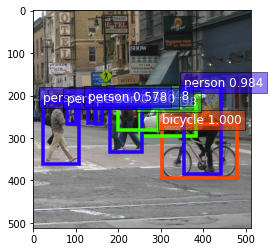

In [7]:
ax = utils.viz.plot_bbox(
    img,
    bounding_boxs.numpy()[0],
    scores.numpy()[0],
    class_IDs.numpy()[0],
    class_names=block.classes,
)
plt.show()

In [19]:
import mxnet as mx

inp = mx.nd.array(x.asnumpy())
block.summary(inp)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (1, 3, 512, 512)               0
   FeatureExpander-1  (1, 1024, 32, 32), (1, 2048, 16, 16), (1, 512, 8, 8), (1, 512, 4, 4), (1, 256, 2, 2), (1, 256, 1, 1)        30997888
            Conv2D-2                             (1, 84, 32, 32)          774228
     ConvPredictor-3                             (1, 84, 32, 32)               0
            Conv2D-4                            (1, 126, 16, 16)         2322558
     ConvPredictor-5                            (1, 126, 16, 16)               0
            Conv2D-6                              (1, 126, 8, 8)          580734
     ConvPredictor-7                              (1, 126, 8, 8)               0
            Conv2D-8                              (1, 126, 4, 4)          580734
     ConvPredictor-9                              (

In [20]:
36927598/(2**20)

35.216901779174805